In [1]:
import os 
import numpy as np
from PIL import Image
from dataloader import Custom_Dataloader
from model import Generator, Discriminator
from utils import train_gen, train_disc
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
data_folder = "/DATA/shrestha/midsem_project/P1_dataset_training/p1"

class Custom_loader(Dataset):
    def __init__(self,data_folder):
        self.data_folder = data_folder
        self.files = sorted(os.listdir(data_folder))[:10]
        
    def __len__(self): return len(self.files)
        
    def pair_image(self,file_name):
        img_pair = {}
        random_img_list = [img for img in self.files if img  != file_name ] # select the images except the first img
        random_img = random.choice(random_img_list)

        img1 = cv2.imread(file_name).astype(np.float32)/255.0
        img1 = cv2.resize(img1,(128,128))
        img_pair['img1'] = img1
       
        pic_img2 = random.choice(os.listdir(os.path.join(data_folder, random_img)))

        img2 = cv2.imread(os.path.join(data_folder, random_img,pic_img2)).astype(np.float32)/255.0
        img2 = cv2.resize(img2,(128,128))
        img_pair['img2'] = img2
        
        return img_pair
    def __getitem__(self,idx):
         # create a list of all the folder classes
        name = self.files[idx] # select specific folder or class
        pic = random.choice(os.listdir(os.path.join(data_folder, name))) # select an image from the identity folder
        
        file_name = os.path.join(data_folder, name,pic)

        data = self.pair_image(file_name)
        
        return data

test_dataset = Custom_loader(data_folder) 
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [4]:
generator = Generator().to(device)
model_weights_path = '/DATA/shrestha/midsem_project/generator_model.pth'
generator.load_state_dict(torch.load(model_weights_path))
generator.eval()

Generator(
  (style_vector_creator): CreateStyleVector(
    (conv1x1): Conv2d(3, 16, kernel_size=(4, 4), stride=(4, 4), bias=False)
    (layer1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer3): Sequential(
      (0): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (decoder): VGGDecoder(
    (decoder_layers): Sequential(
      (0): ConvTranspose2d(1000, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2,

In [5]:
def visualize_output(img1,img2,output):
    img1 = img1.cpu().detach().numpy().transpose(0, 2, 3, 1)
    img2 = img2.cpu().detach().numpy().transpose(0, 2, 3, 1)
    output = output.cpu().detach().numpy().transpose(0, 2, 3, 1)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(np.asarray(img1[0]))
    ax[0].axis('off')  # Turn off axis
    ax[0].set_title('Img1')  # Set caption

    # Plot the second image with caption
    ax[1].imshow(np.asarray(img2[0]))
    ax[1].axis('off')  # Turn off axis
    ax[1].set_title('Img2')  # Set caption

    # Plot the combined image with caption
    ax[2].imshow(np.asarray(output[0]))
    ax[2].axis('off')  # Turn off axis
    ax[2].set_title('Combined Img')  # Set caption

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

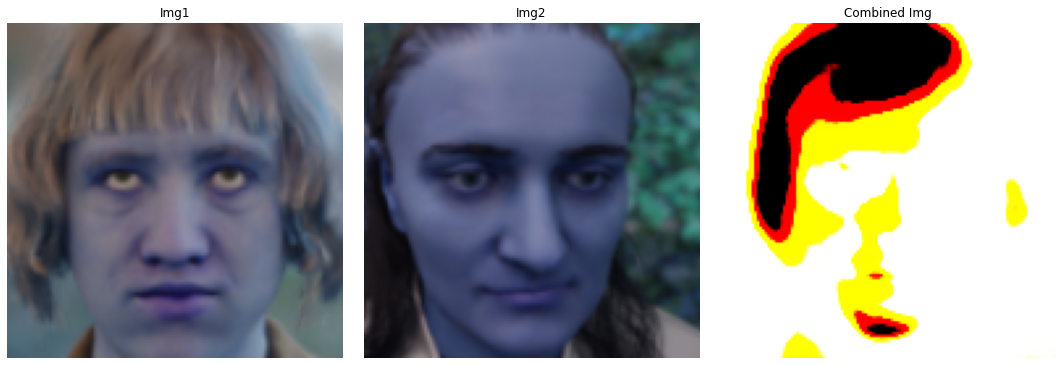

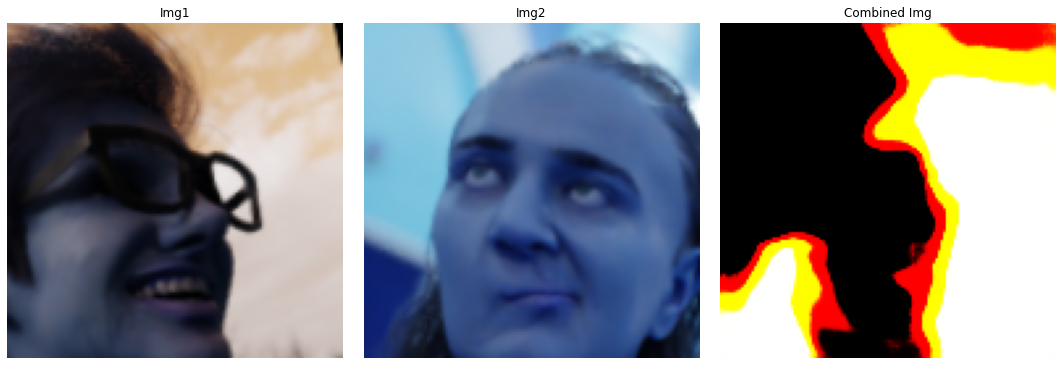

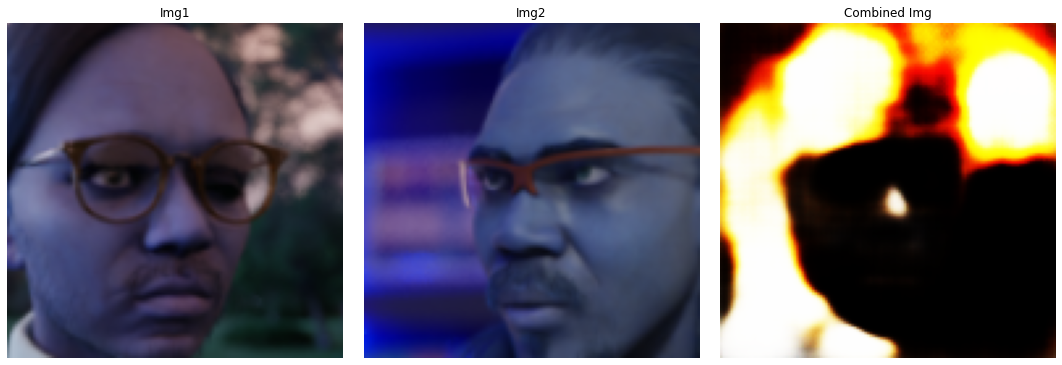

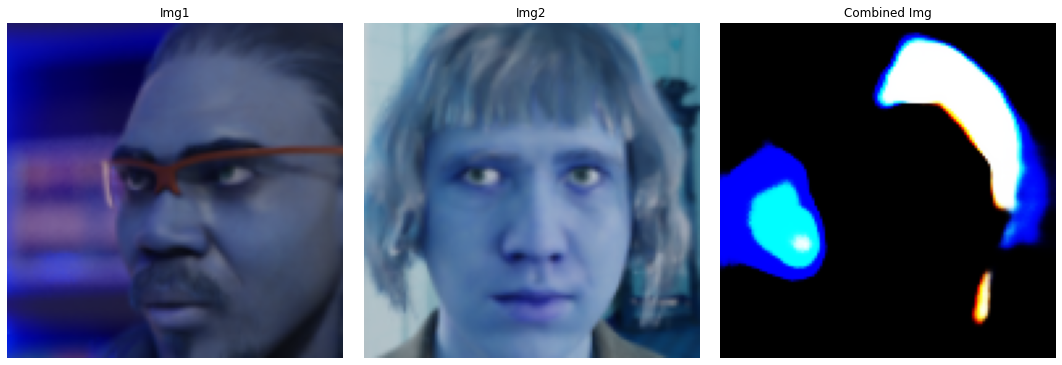

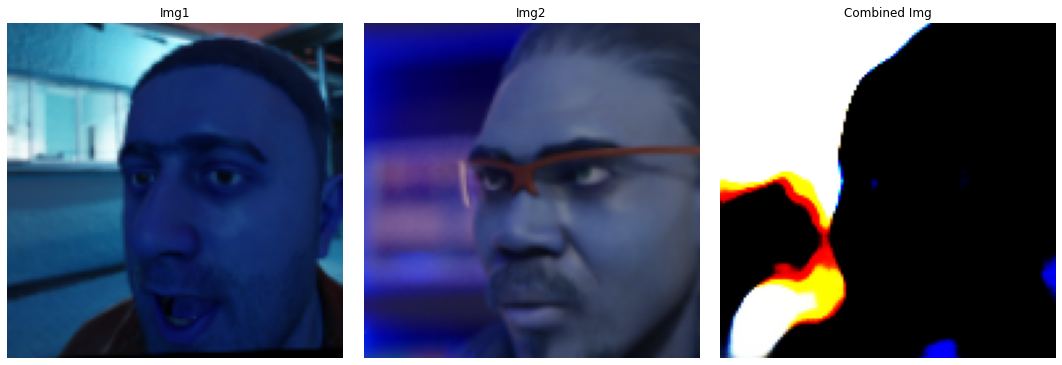

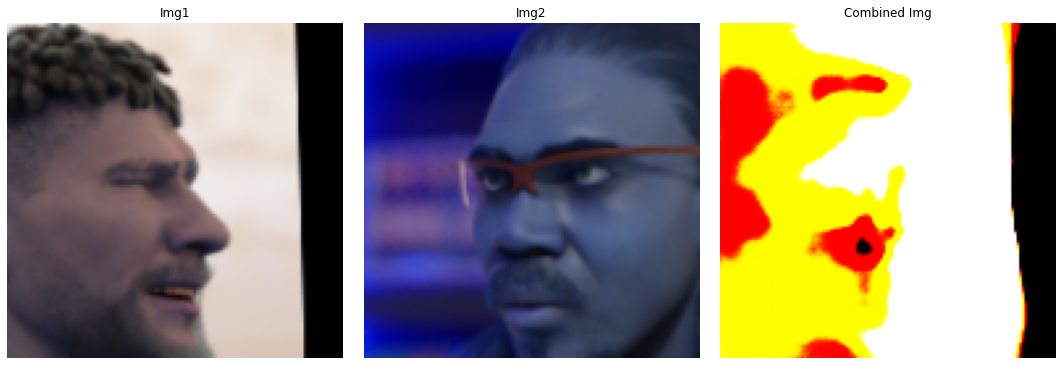

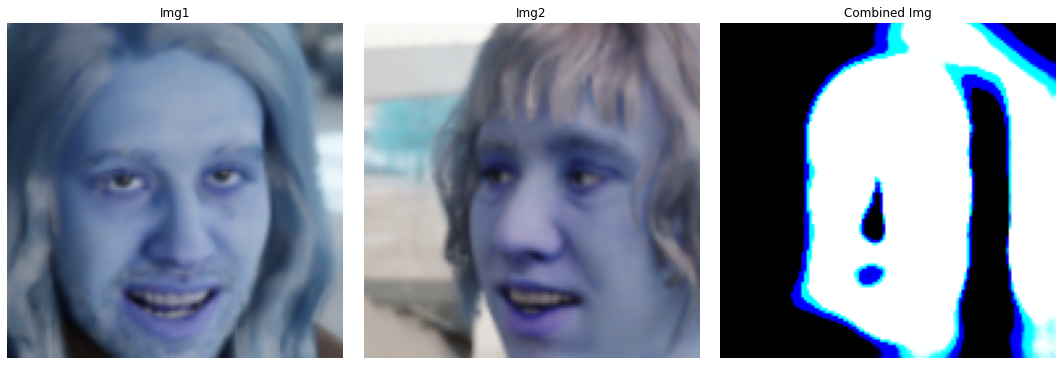

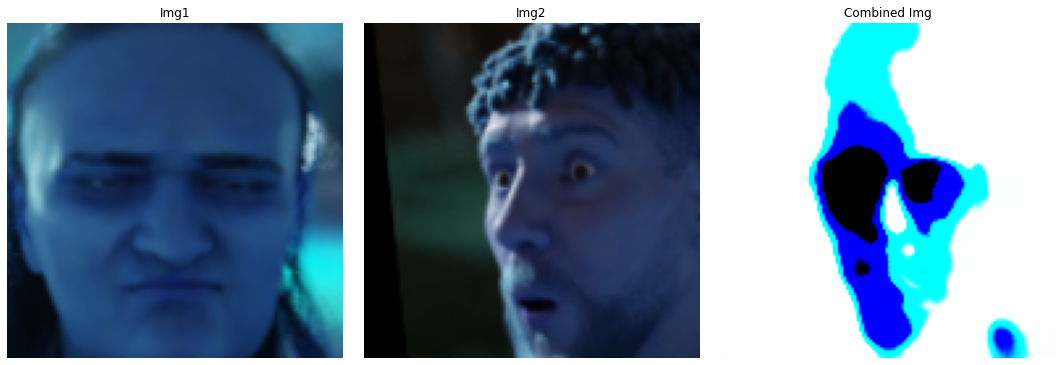

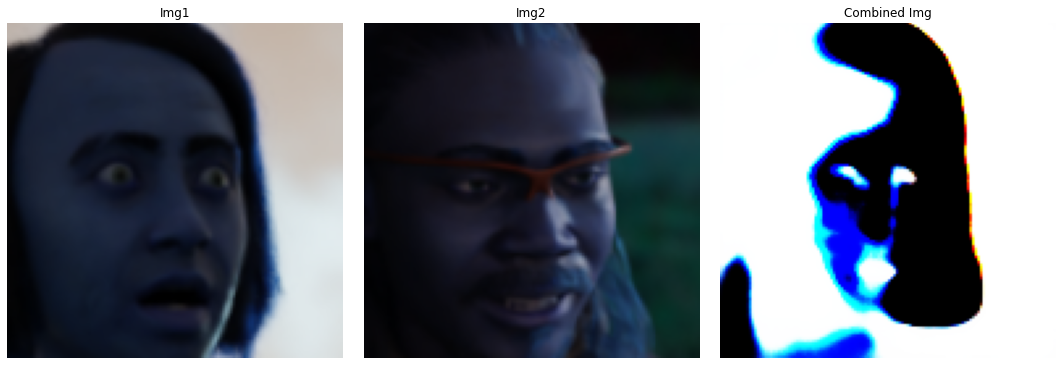

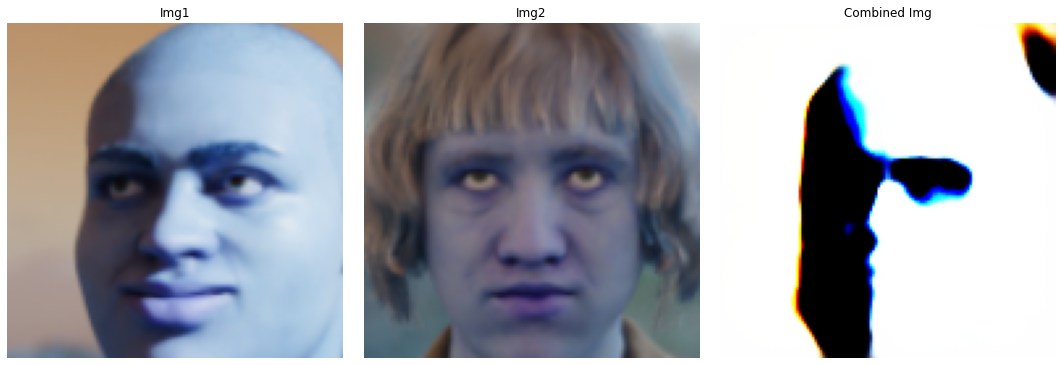

In [6]:
with torch.no_grad():
    for data in test_dataloader:
        img1 = data['img1'].permute(0, 3, 1, 2).float().to(device)
        
        img2 = data['img2'].permute(0, 3, 1, 2).float().to(device)

        gen_output = generator(img1, img2)

        visualize_output(img1, img2, gen_output)
        